In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

C:\Users\Java\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Platform: Windows-10-10.0.16299-SP0
Tensorflow version: 1.5.0
Keras version: 2.1.3


In [2]:
import os, shutil
# 專案的根目錄路徑
os.chdir('D:\\BB105Project\\dogrecognition\\Model')

ROOT_DIR = os.getcwd()

print(os.getcwd())

breed_dir =  os.listdir('data\\train')[:16]


# 置放coco圖像資料與標註資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 原始數據集的路徑 ./data/train
original_dataset_dir = os.path.join(DATA_PATH, "train")

# 存儲小數據集的目錄 ./data/cats_and_dogs_small
base_dir = os.path.join(DATA_PATH, "dog_breed")
if not os.path.exists(base_dir): 
    os.mkdir(base_dir)
    
#----------------------------------------------------------

# 我們的訓練資料的目錄 ./data/cats_and_dogs_small/train
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): 
    os.mkdir(train_dir)

# 我們的驗證資料的目錄 ./data/cats_and_dogs_small/validation
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir): 
    os.mkdir(validation_dir)

# 我們的測試資料的目錄 ./data/cats_and_dogs_small/test
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
#----------------------------------------------------------  

# 狗種的圖片的訓練資料目錄 ./data/cats_and_dogs_small/train/cats
for breed in breed_dir:
    train_cats_dir = os.path.join(train_dir, breed)
    if not os.path.exists(train_cats_dir):
        os.mkdir(train_cats_dir)

    
# 狗種的圖片的驗證資料目錄 ./data/cats_and_dogs_small/validation/cats
for breed in breed_dir:
    validation_cats_dir = os.path.join(validation_dir, breed)
    if not os.path.exists(validation_cats_dir):
        os.mkdir(validation_cats_dir)

    
# 狗種的圖片的測試資料目錄 ./data/cats_and_dogs_small/test/cats
for breed in breed_dir:
    test_cats_dir = os.path.join(test_dir, breed)
    if not os.path.exists(test_cats_dir):
        os.mkdir(test_cats_dir)
    
#----------------------------------------------------------

# 複製前400個狗種的圖片到train_cats_dir
for breed in breed_dir:
    breed_path = os.path.join(original_dataset_dir,breed)
    train_path = os.path.join(train_dir,breed)
    fnames = os.listdir(breed_path)[:400]
    for fname in fnames:
        src = os.path.join(breed_path, fname)
        dst = os.path.join(train_path, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

print('Copy first 200 breed images to train_breed_dir complete!')

# 複製下100個狗種的圖片到validation_cats_dir
for breed in breed_dir:
    breed_path = os.path.join(original_dataset_dir,breed)
    validation_path = os.path.join(validation_dir,breed)
    fnames = os.listdir(breed_path)[400:500]
    for fname in fnames:
        src = os.path.join(breed_path, fname)
        dst = os.path.join(validation_path, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

print('Copy next 50 brees images to validation_breed_dir complete!')

# 複製下500個貓的圖片到test_cats_dir
#fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
#for fname in fnames:
#    src = os.path.join(original_dataset_dir, fname)
#    dst = os.path.join(test_cats_dir, fname)
#    if not os.path.exists(dst):
#        shutil.copyfile(src, dst)

#print('Copy next 500 cat images to test_cats_dir complete!')



#print('total training cat images:', len(os.listdir(train_cats_dir)))
#print('total training dog images:', len(os.listdir(train_dogs_dir)))
#print('total validation cat images:', len(os.listdir(validation_cats_dir)))
#print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
#print('total test cat images:', len(os.listdir(test_cats_dir)))
#print('total test dog images:', len(os.listdir(test_dogs_dir)))

D:\BB105Project\dogrecognition\Model
Copy first 200 breed images to train_breed_dir complete!
Copy next 50 brees images to validation_breed_dir complete!


# 特徵提取 (feature extraction)
特徵提取包括了使用預訓練好的網絡模型來從新樣本中提取特徵。這些特徵通過一個"新"的分類器(從頭開始訓練)。

實例化一個VGG16模型：

In [3]:
from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False, # 在這裡告訴 keras我們只需要卷積基底的權重模型資訊
                        input_shape=(150,150,3)) # 宣告我們要處理的圖像大小與顏色通道數

我們向構造函數傳遞了三個參數：

weights, 指定從哪個權重檢查點從中初始化模型

include_top, 這是指在網絡頂部要包括或不包含密集連接的分類器。默認情況下，這個密集連接的分類器將對應於ImageNet的1000個類別。因為我們打算用自己建構的分類器（只有兩個類別，貓和狗），因此我們不需要包括它。

input_shape, 我們將餵進到網絡的圖像張量的形狀(shape)。這個參數純粹是可選的：如果我們設定，那麼網絡將能夠處理任何大小的輸入。
以下是VGG16“卷積基底”架構的細節：它與您已經熟悉的簡單卷積網絡(convnets)非常相似。

In [4]:
conv_base.summary() # 打印一下模型資訊

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## 方法2: (卷積基底:凍結 + 串接新的密集分類層) >> 重新訓練

現在，我們來回顧一下我們提到的第二種特徵提取技術，這種方法要慢得多，而且會花更多的時間與計算資源，但是我們可以在訓練過程中利用數據擴充(data augmentation): 擴展conv_base模型，並進行端(end)對端(end)的訓練。

請注意，這種手法真的是非常昂貴的，所以只有在你有GPU時才應該嘗試它：在CPU上是絕對棘手的。如果您無法在GPU上運行代碼，那麼前一個手法就是你要選的路。

因為模型的行為就像堆積木，所以你可以添加一個模型（像我們的conv_base）到Sequential模型，就像添加一個圖層一樣。所以你可以執行以下操作：

### 移花+接木

In [5]:
from keras import models
from keras import layers

model = models.Sequential() # 產生一個新的網絡模型結構
model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(16, activation='softmax')) # 因為我的資料集只有兩類(cat & dog)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 26,525,744
Trainable params: 26,491,312
Non-trainable params: 34,432
_________________________________________________________________


In [7]:
# 看一下“凍結前”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192


In [8]:
# “凍結”卷積基底
conv_base.trainable = False

In [9]:
# 再看一下“凍結後”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import datetime as dt
start = dt.datetime.now()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=20,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

start = dt.datetime.now()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Found 6400 images belonging to 16 classes.
Found 1600 images belonging to 16 classes.
Epoch 1/30
100/100 [==============================] - 61s 613ms/step - loss: 2.7331 - acc: 0.1335 - val_loss: 2.4199 - val_acc: 0.3860
Epoch 2/30
100/100 [==============================] - 53s 525ms/step - loss: 2.3939 - acc: 0.2360 - val_loss: 2.1635 - val_acc: 0.5180
Epoch 3/30
100/100 [==============================] - 52s 525ms/step - loss: 2.2627 - acc: 0.2930 - val_loss: 2.1554 - val_acc: 0.5640
Epoch 4/30
100/100 [==============================] - 28s 282ms/step - loss: 2.1680 - acc: 0.3210 - val_loss: 1.8229 - val_acc: 0.6380
Epoch 5/30
100/100 [==============================] - 26s 257ms/step - loss: 2.0998 - acc: 0.3395 - val_loss: 2.1477 - val_acc: 0.6070
Epoch 6/30
100/100 [==============================] - 26s 260ms/step - loss: 2.0369 - acc: 0.3560 - val_loss: 2.0524 - val_acc: 0.6430
Epoch 7/30
100/100 [==============================] - 27s 267ms/step - loss: 1.9905 - acc: 0.3715 - val_

In [11]:
model.save('breed16_InceptionV3_1.h5') # 把模型儲存到檔案

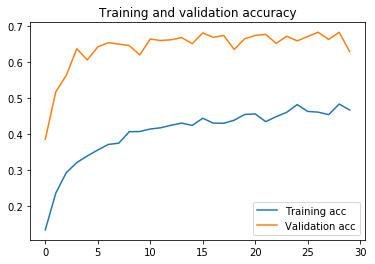

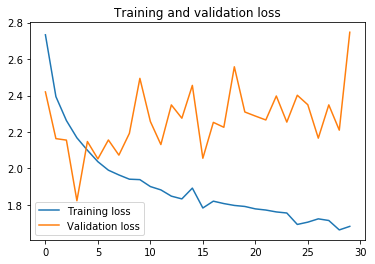

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 微調 (fine-tuning)

另一種廣泛使用的模型重覆利用技術，與_特徵提取(feature extraction)_相輔相成，是 _(微調) fine-tuning_。

微調包括解凍用於特徵提取的凍結模型庫中的幾個頂層(top layers)，並且共同訓練新添加的模型部分（在我們的範例中是完全連接的分類器）和這些頂層。這被稱為“微調(fine-tuning)”，因為它稍微調整正在重複使用的模型中更抽象的表示，以使它們與當前的要處理的問題更相關。

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [18]:
conv_base.trainable = True # 解凍 "卷積基底"

# 所有層直到block4_pool都應該被凍結，而 block5_conv1，block5_conv2, block5_conv3 及 block5_pool則被解凍        
layers_frozen = ['conv2d_90','batch_normalization_90','activation_90',
                 'conv2d_87','conv2d_91','batch_normalization_87','batch_normalization_91','activation_87',
                 'activation_91','conv2d_88','conv2d_89','conv2d_92','conv2d_93','average_pooling2d_9','conv2d_86',
                 'batch_normalization_88','batch_normalization_89','batch_normalization_92',
                 'batch_normalization_93','conv2d_94','batch_normalization_86','activation_88',
                 'activation_89','activation_92','activation_93','batch_normalization_94',
                 'activation_86','mixed9_1','concatenate_2','activation_94','mixed10']
for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 把每一層是否可以被"trainable"的flat打印出來
for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable))

input_1: False
conv2d_1: False
batch_normalization_1: False
activation_1: False
conv2d_2: False
batch_normalization_2: False
activation_2: False
conv2d_3: False
batch_normalization_3: False
activation_3: False
max_pooling2d_1: False
conv2d_4: False
batch_normalization_4: False
activation_4: False
conv2d_5: False
batch_normalization_5: False
activation_5: False
max_pooling2d_2: False
conv2d_9: False
batch_normalization_9: False
activation_9: False
conv2d_7: False
conv2d_10: False
batch_normalization_7: False
batch_normalization_10: False
activation_7: False
activation_10: False
average_pooling2d_1: False
conv2d_6: False
conv2d_8: False
conv2d_11: False
conv2d_12: False
batch_normalization_6: False
batch_normalization_8: False
batch_normalization_11: False
batch_normalization_12: False
activation_6: False
activation_8: False
activation_11: False
activation_12: False
mixed0: False
conv2d_16: False
batch_normalization_16: False
activation_16: False
conv2d_14: False
conv2d_17: False
batch_n

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 使用小的learn rate
              metrics=['acc'])

start = dt.datetime.now()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Epoch 1/50
100/100 [==============================] - 34s 337ms/step - loss: 1.5215 - acc: 0.5240 - val_loss: 1.3803 - val_acc: 0.6010
Epoch 2/50
100/100 [==============================] - 30s 296ms/step - loss: 1.5363 - acc: 0.5220 - val_loss: 1.4778 - val_acc: 0.5720
Epoch 3/50
100/100 [==============================] - 30s 295ms/step - loss: 1.5542 - acc: 0.5160 - val_loss: 1.3799 - val_acc: 0.5780
Epoch 4/50
100/100 [==============================] - 30s 299ms/step - loss: 1.4620 - acc: 0.5445 - val_loss: 1.3903 - val_acc: 0.5910
Epoch 5/50
100/100 [==============================] - 30s 295ms/step - loss: 1.5528 - acc: 0.5020 - val_loss: 1.4366 - val_acc: 0.5860
Epoch 6/50
100/100 [==============================] - 30s 295ms/step - loss: 1.5297 - acc: 0.5280 - val_loss: 1.3700 - val_acc: 0.5870
Epoch 7/50
100/100 [==============================] - 29s 295ms/step - loss: 1.4927 - acc: 0.5195 - val_loss: 1.3653 - val_acc: 0.5930
Epoch 8/50
100/100 [==============================] - 3

In [20]:
model.save('breed16_InceptionV3_tunning_1.h5')

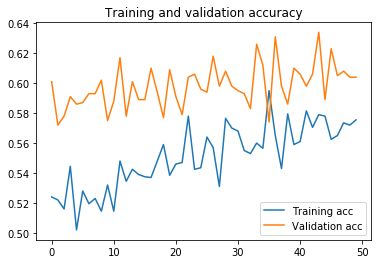

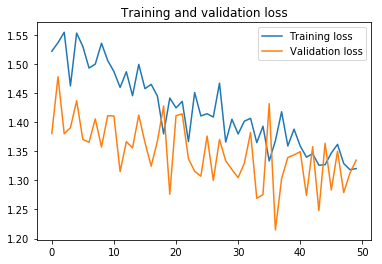

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

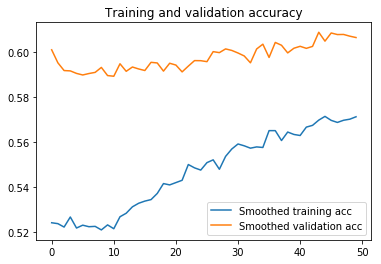

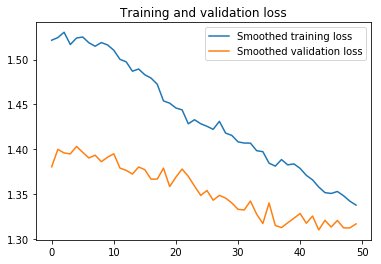

In [22]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()